# Validation - Initial Parameters

Generates the plots presented in SynthPop Paper 1, Section 6.1

Initial version: Jonas Klüter, 2023-06-29

Revised: Macy Huston, 2025-02-04

In [6]:
# Imports

import sys
import os
import numpy as np
import pandas
import matplotlib.pyplot as plt
import pandas as pd

DIRNAME = os.path.abspath(os.getcwd())

import synthpop

def get_color_iter(n):
    return iter(['red', 'green', 'blue', 'gold'])

In [33]:
# SynthPop Configuration

config = {
    "name_for_output":"validation_model",
    "model_name": "validation_model",
    "l_set": [0,90, 12.17, 39.14],
    "max_distance":25,
    "b_set":[0, 0, 5.37, 8.53],
    "l_set_type":"pairs",
    "b_set_type":"pairs",
    "solid_angle":[1e-4,3e-2,1e-3, 1e-2],
    "extinction_map_kwargs": {
        "name":"MapsFromDustmaps", "dustmap_name":"marshall"
        },
    "output_file_type":"hdf5",
    "obsmag": False,
    "chosen_bands": ["Bessell_B", "Bessell_V", "Bessell_I"],
    "maglim": ["Bessell_V", 99999, "keep"],
    "lost_mass_option": 1,
    "overwrite":True
}

# set up SynthPop model
model = synthpop.SynthPop(**config)
# initialize populations
model.init_populations()



################################ Settings #################################
# reading default parameters from
default_config_file =  /u/mhuston/code/synthpop/synthpop/config_files/_default.synthpop_conf 


# copy the following to a config file to redo this model generation -------
{
    "l_set": [
        0,
        90,
        12.17,
        39.14
    ],
    "l_set_type": "pairs",
    "b_set": [
        0,
        0,
        5.37,
        8.53
    ],
    "b_set_type": "pairs",
    "name_for_output": "validation_model",
    "model_name": "validation_model",
    "solid_angle": [
        0.0001,
        0.03,
        0.001,
        0.01
    ],
    "solid_angle_unit": "deg^2",
    "random_seed": 578630442,
    "sun": {
        "x": -8.178,
        "y": 0.0,
        "z": 0.017,
        "u": 12.9,
        "v": 245.6,
        "w": 7.78,
        "l_apex_deg": 56.24,
        "b_apex_deg": 22.54
    },
    "lsr": {
        "u_lsr": 1.8,
        "v_lsr": 233.4,
        "w_lsr": 0.53
    },
   

In [34]:
# SynthPop Catalog Generation

# place to collect the data from different line of sights
data = {}
# loop over all location
for i,loc in enumerate(model.get_iter_loc()):
    # run synthpop for the given location and solid angle
    data_loc, distribution = model.process_location(
        *loc, model.parms.solid_angle[i], model.parms.solid_angle_unit,
        save_data=False)

    # store data in the dictionary
    data[loc] = data_loc
combined_data = pandas.concat([d for d in data.values()])



############################# update location #############################
# set location to: 
l, b = (0.00 deg, 0.00 deg)
# set solid_angle to:
solid_angle = 1.000e-04 deg^2


############################# Generate Field ##############################


# Population 0;  test_population_0 ----------------------------------------
# From density profile (number density)
expected_total_iMass = 11102.2598
expected_total_eMass = 5921.8602
average_iMass_per_star = 0.6045
mass_loss_correction = 0.5334
n_expected_stars = 18366.1552
# Determine velocities when position are generated 
# From Generated Field:
generated_stars = 18415
generated_total_iMass = 11216.6490
generated_total_eMass = 5949.6568
det_mass_loss_corr = 0.5304
# Done


# Population 1;  test_population_1 ----------------------------------------
# From density profile (number density)
expected_total_iMass = 2295.2599
expected_total_eMass = 1258.6989
average_iMass_per_star = 0.5739
mass_loss_correction = 0.5484
n_expected_stars 

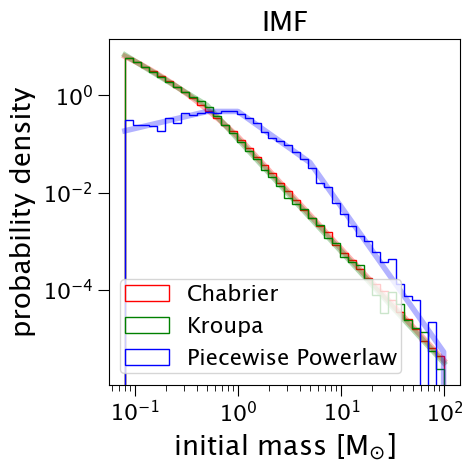

In [55]:
def validate_imf(comp_data, populations=(0, 1, 2)):
    """ plot the given imf and resulting distribution"""
    color = get_color_iter(len(populations))
    plt.figure(figsize=(5,5))
    x = np.logspace(np.log10(model.parms.mass_lims['min_mass']),
                    np.log10(model.parms.mass_lims['max_mass']), 1001)

    for i in populations:
        c=next(color)

        # get the imf for the current population
        imf = model.populations[i].imf
        # normalise the IMF to an area of 1
        norm = imf.F_imf(model.parms.mass_lims['max_mass'])\
               -imf.F_imf(model.parms.mass_lims['min_mass'])
        # plot input imf
        plt.loglog(x, imf.imf(x)/norm,c=c, alpha=0.3, lw=4)

        # select stars generated for the current population
        population_mask = combined_data['pop'] == i
        # plot histogramm
        plt.hist(comp_data.iMass[population_mask], bins=x[::25],
            histtype='step', color=c, density=True, label=imf.imf_name)
    plt.title('IMF')
    plt.ylabel('probability density')
    plt.xlabel('initial mass [M$_{\odot}]$')
    plt.legend()
    plt.tight_layout()
    plt.savefig('validation_figures/validate_imf.pdf')
validate_imf(combined_data)

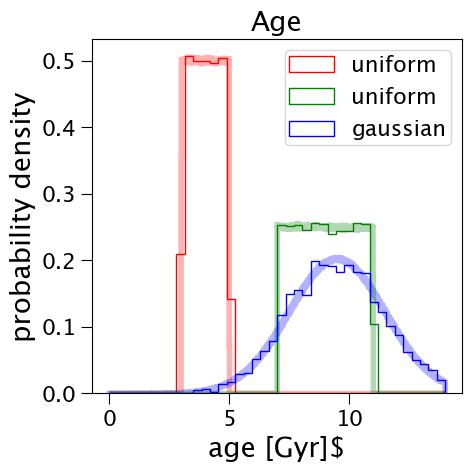

In [56]:
def validate_age(comp_data, populations=(0, 1, 2)):
    """ plot the given imf and resulting distribution"""
    color = get_color_iter(len(populations))
    plt.figure(figsize=(5,5))
    x = np.linspace(0,14, 1001)

    for i in populations:
        c=next(color)

        # get the imf for the current population
        age = model.populations[i].age
        # normalise the IMF to an area of 1

        # plot input metallicity
        plt.hist(age.draw_random_age(10_000_000), bins=x, density=True,
            histtype="step", lw=4, color=c, alpha=0.3)

        #select stars generated for the current population
        population_mask = combined_data['pop'] == i
        #plot histogramm
        plt.hist(comp_data.loc[population_mask,'age'], bins=x[::25],
            histtype='step', color=c, density=True, label=age.age_func_name)
    plt.title('Age')
    plt.ylabel('probability density')
    plt.xlabel('age [Gyr]$')
    plt.legend()
    plt.tight_layout()
    plt.savefig('validation_figures/validate_age.pdf')
validate_age(combined_data)

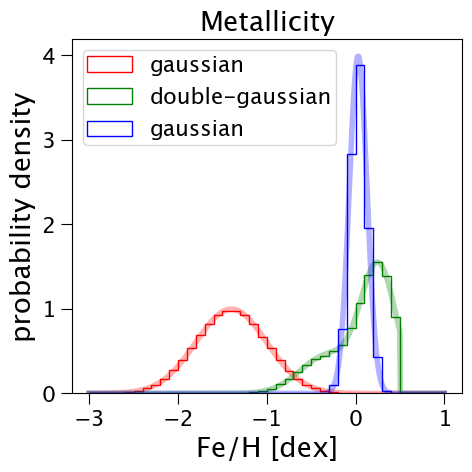

In [57]:
def validate_met(comp_data, populations=(0, 1, 2)):
    """ plot the given imf and resulting distribution"""
    color = get_color_iter(len(populations))
    plt.figure(figsize=(5,5))
    x = np.linspace(-3,1, 1001)

    for i in populations:
        c=next(color)

        # get the imf for the current population
        met = model.populations[i].metallicity
        # normalise the IMF to an area of 1
        plt.plot(x, met.likelyhood_distribution(x),c=c,lw=4, alpha=0.3)

        #select stars generated for the current population
        population_mask = combined_data['pop'] == i
        #plot histogramm
        plt.hist(comp_data.loc[population_mask,'Fe/H_initial'], bins=x[::25],
            histtype='step', color=c, density=True, label=met.metallicity_func_name)

    plt.title('Metallicity')
    plt.ylabel('probability density')
    plt.xlabel('Fe/H [dex]')
    plt.legend()
    plt.tight_layout()
    plt.savefig('validation_figures/validate_met.pdf')
validate_met(combined_data)